In [1]:
import numpy as np
import matplotlib.pyplot as plt
import arrow
import datetime
import xarray as xr
import os
import cmocean.cm as cm
import matplotlib.cm as cma
import scipy.interpolate as interp
from matplotlib.collections import PatchCollection
import matplotlib.dates as mpl_dates
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FormatStrFormatter
import datetime as dt
import pandas as pd
import matplotlib.dates as mpl_dates
import scipy.stats as stats
from matplotlib.ticker import StrMethodFormatter

### Functions

In [2]:
#Function to extract data from 1 section
def get_secdata(datafile,sectionnum):
    
    variables = ['final_salt','final_transp','final_lon','final_lat','final_depth','final_section','final_z','final_temp','init_lon','init_z','init_salt','init_temp','init_transp','final_age']
    
    dict_var = {}
    
    idx = np.where(datafile['final_section']==sectionnum)
    
    for var in variables:
        if var == 'final_age':
            agetd = datafile[var].values
            agehr = agetd.astype('float64')/(10**9*3600)
            age = agehr[idx]
            dict_var[var] = age
        else:
            data_sec = datafile[var]
            dict_var[var] = data_sec[idx]
        
    
    return dict_var

def plotCS(axv,lonsec,zsec,transpsec,lonW,lonE,latgridi,depi,vmax,time,title,cblabel,ylabel):
    
    latgridf = latgridi-1
    fmask = mesh.fmask[0, :, latgridf]
    tmask = mesh.tmask[0]
    
    lons = data.init_lon[(data.final_section != 0)]
    
    f_lons = mesh.glamf[0, latgridf]
    u_lons = mesh.glamv[0, latgridf]
    w_depths = mesh.gdepw_1d

    m2lon = ((u_lons[lonE]-u_lons[lonW])/(mesh.e2f[0, latgridi, lonW:lonE].sum())).values #degrees/m
    
    cmap = cm.deep
    
    arr,xe,ye,im = axv.hist2d(lonsec/m2lon,df(zsec)[0],weights=transpsec,cmap=cmap,bins=[np.array(f_lons[lonW:lonE:1]/m2lon),w_depths[0,0:depi]],
                              density=True,vmax=vmax
                                )
    
    X,Y = np.meshgrid(xe,ye)
    
    im = axv.pcolormesh(X,Y,arr.T*np.sum(transpsec/time).values,cmap=cmap,vmax=vmax)
    
    axv.invert_yaxis()
    axv.set_title(title)
    axv.set_xlabel('Longitude (°E)')
    axv.set_xticks(np.linspace(f_lons[lonW+2]/m2lon,f_lons[lonE-2]/m2lon,2))
    axv.xaxis.set_major_formatter(FormatStrFormatter(f"%.{2}f"))
    axv.set_xticklabels(['{:.2f}'.format(label) for label in np.linspace(f_lons[lonW+2],f_lons[lonE-2],2)])
    axv.set_xticklabels(np.round(np.linspace(f_lons[lonW+2],f_lons[lonE-2],2),2))
    
    pc = draw_patches(fmask, lonW, lonE, np.array(u_lons), np.array(w_depths[0]),m2lon)
    axv.add_collection(pc)

    if cblabel == True:
        cb = fig.colorbar(im,ax=axv)
        cb.set_label('Transport (m/s)')
    
    if ylabel == True:
        axv.set_ylabel('Depth (m)')
        
    else: 
        axv.set_yticklabels([])

def plotTS(axn,var,lonsec,zsec,varsec,lonW,lonE,latgridi,depi,time,title,cblabel,ylabel,vmin=None,vmax=None):
    
    latgridf = latgridi-1
    fmask = mesh.fmask[0, :, latgridf]
    tmask = mesh.tmask[0]
    
    lons = data.init_lon[(data.final_section != 0)]
    
    f_lons = mesh.glamf[0, latgridf]
    u_lons = mesh.glamv[0, latgridf]
    w_depths = mesh.gdepw_1d

    m2lon = ((u_lons[lonE]-u_lons[lonW])/(mesh.e2f[0, latgridi, lonW:lonE].sum())).values #degrees/m
    
    cmap = cm.deep
    
    m2lon = ((u_lons[lonE]-u_lons[lonW])/(mesh.e2f[0, latgridi, lonW:lonE].sum())).values #degrees/m
    
    arrw,xe,ye,im = axn.hist2d(lonsec/m2lon,df(zsec)[0],weights=varsec,cmap=cmap,bins=[np.array(f_lons[lonW:lonE:1]/m2lon),w_depths[0,0:depi]])
    arrnw,xe2,ye2,im2 = axn.hist2d(lonsec/m2lon,df(zsec)[0],cmap=cmap,bins=[np.array(f_lons[lonW:lonE:1]/m2lon),w_depths[0,0:depi]])
    
    arr3 = arrw/arrnw
    
    X,Y = np.meshgrid(xe,ye)
    
    im = axn.pcolormesh(X,Y,arr3.T,vmin=vmin,vmax=vmax)
    axn.set_xlabel('Longitude (°E)')
    axn.set_title(title)
    axn.invert_yaxis()
    axn.set_xticks(np.linspace(f_lons[lonW]/m2lon,f_lons[lonE-1]/m2lon,2))
    axn.set_xticklabels(['{:.2f}'.format(label) for label in np.linspace(f_lons[lonW],f_lons[lonE-1],2)])
    
    if cblabel == True:
        cb = fig.colorbar(im,ax=axn)
        
        if var == 'temp':
            cb.set_label('Temperature (°C)')
        if var == 'sal':
            cb.set_label('Salinity (g/kg)')
            
    if ylabel == True:
        axn.set_ylabel('Depth (m)')
    else:
        axn.set_yticks([])
        
def get_datat(datafile,section, starttime, endtime):
    final_section = datafile.final_section
    final_transport = datafile.final_transp
    transports = np.sum(np.where(final_section == section, final_transport, 0)) 
    return transports/(endtime-starttime+1)

def running_mean(data, window_size):
    cumsum = np.cumsum(data)
    cumsum[window_size:] = cumsum[window_size:] - cumsum[:-window_size]
    return cumsum[window_size - 1:] / window_size

def draw_patches(fmask, ll, ul, u_lons, w_depths,m2lon):
    topo = []
    for i in range(ll, ul):
        for j in range(39):
            if fmask[j, i] == 0:
                try:
                    rect = Rectangle((u_lons[i]/m2lon, w_depths[j+1]), u_lons[i+1]/m2lon-u_lons[i]/m2lon, w_depths[j+2]-w_depths[j+1])
                    topo.append(rect)
                except:
                    pass

    pc = PatchCollection(topo, facecolors='lightgray', edgecolors='none')
    return(pc)

In [3]:
def plotCSNS(axv,lonsec,zsec,transpsec,lonW,lonE,latgridi,depi,vmax,time,title,cblabel,ylabel):
    
    latgridf = latgridi-1 #actually lon
    fmask = mesh.fmask[0,:,:,latgridf] # Giving mask of longitudes
    tmask = mesh.tmask[0]
    
    lons = data.init_lat[(data.final_section != 0)]
    
    f_lons = mesh.gphif[0,:, latgridf]
    u_lons = mesh.gphiv[0,:, latgridf]
    w_depths = mesh.gdepw_1d

    m2lon = ((u_lons[lonE]-u_lons[lonW])/(mesh.e2f[0, latgridi, lonW:lonE].sum())).values #degrees/m
    
    cmap = cm.deep
    
    arr,xe,ye,im = axv.hist2d(lonsec/m2lon,df(zsec)[0],weights=transpsec,cmap=cmap,bins=[np.array(f_lons[lonW:lonE:1]/m2lon),w_depths[0,0:depi]],
                              density=True,vmax=vmax
                                )
    
    X,Y = np.meshgrid(xe,ye)
    
    im = axv.pcolormesh(X,Y,arr.T*np.sum(transpsec/time).values,cmap=cmap,vmax=vmax)
    
    axv.invert_yaxis()
    axv.set_title(title)
    axv.set_xlabel('Latitude (°W)')
    axv.set_xticks(np.linspace(f_lons[lonW+2]/m2lon,f_lons[lonE-2]/m2lon,2))
    axv.xaxis.set_major_formatter(FormatStrFormatter(f"%.{2}f"))
    axv.set_xticklabels(['{:.2f}'.format(label) for label in np.linspace(f_lons[lonW+2],f_lons[lonE-2],2)])
    axv.set_xticklabels(np.round(np.linspace(f_lons[lonW+2],f_lons[lonE-2],2),2))
    
    pc = draw_patches(fmask, lonW, lonE, np.array(u_lons), np.array(w_depths[0]),m2lon)
    axv.add_collection(pc)

    if cblabel == True:
        cb = fig.colorbar(im,ax=axv)
        cb.set_label('Transport (m/s)')
    
    if ylabel == True:
        axv.set_ylabel('Depth (m)')
        
    else: 
        axv.set_yticklabels([])

## Import data

In [4]:
data = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/for_jan18/for_straight_01jan18_s7t28/ariane_positions_quantitative.nc')
mesh = xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask202108.nc')

lonW = 308
lonE = 327
latgridi = 300
latgridf = latgridi-1
fmask = mesh.fmask[0, :, latgridi]
tmask = mesh.tmask[0]
    
lons = data.init_lon[(data.final_section != 0)]
    
f_lons = mesh.glamf[0, latgridi]
u_lons = mesh.glamv[0, latgridi]
w_depths = mesh.gdepw_1d

m2lon = ((u_lons[lonE]-u_lons[lonW])/(mesh.e2f[0, latgridi, lonW:lonE].sum())).values #degrees/m

df = interp.interp1d(mesh.z,mesh.gdepw_1d) # Interpolate to get same binning scheme as SalishSeaCast

In [5]:
#Importing data and calculating section transport 
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)

files = ['forpr_ros3','backadm_ros3','backvs_ros3']
namen = ['datafvs']

starttime = 1
endtime = 24
sectionnum = [0,1,2,3,4,5,6,7,8]

date = dt.datetime(2016,12,10)
enddate = dt.datetime(2021,12,27)

dates = []
datelist_vs = []

while date <= enddate:
    dates.append(date.strftime('%d%b%y').lower())
    datelist_vs.append(date)
    date+=dt.timedelta(days=1)
     
dicts = {}

for i,file in enumerate(files):
    dict_i = {}
    
    for date in dates:
        name = '/ocean/cstang/MOAD/analysis-camryn/Ariane/' + file + '/' + date + '_s1t50/ariane_positions_quantitative.nc'
        
        if os.path.isfile(name):
            dict_i[date] = xr.open_dataset(name)
        
    dicts[file] = dict_i
    
dict_sectiontransp = {}

for file in files:
    st_dict = {}
    for var in dicts[file].keys():
        if var not in st_dict:
            st_dict[var] = []
        for section in sectionnum:
            st_dict[var].append(get_datat(dicts[file][var],section,starttime,endtime))
        dict_sectiontransp[file] = st_dict

dict_age = {}

for file in files:
    a_dict = {}
    
    for date in dicts[file].keys():
        if date not in a_dict:
            a_dict[date] = []
        for section in sectionnum:
            allvar = get_secdata(dicts[file][date],section)
            a_dict[date].append(np.mean(allvar['final_age'][allvar['final_age']>=24]))
    dict_age[file] = a_dict

age_2018 = {}

for file in files:
    
    if file not in age_2018:
        age_2018[file] = {}
    
    for section in sectionnum:
        
        if section not in age_2018[file]:
            
            age_2018[file][section] = []
            
        for date in dicts[file].keys():
            
            age_2018[file][section].append(dict_age[file][date][section])
            
transp_2018 = {}

for file in files:
    
    transp_2018[file] = []
    
    for date in dates:
        try:
            transp_2018[file].append(np.sum(dict_sectiontransp[file][date][2:]))
        except:
            pass
        
sectransp_2018 = {}

for file in files:
    sectransp_2018[file] = {}
    
    for section in sectionnum:
        if section not in sectransp_2018[file]:
            sectransp_2018[file][section] = []
            
        for date in dates:
            try:
                sectransp_2018[file][section].append(dict_sectiontransp[file][date][section])
            except:
                print(date)
                pass


In [6]:
dict_secdata = {}

for file in files:
    
    if file not in dict_secdata:
        dict_secdata[file] = {}
    
    
    for section in sectionnum:
        
        if section not in dict_secdata[file]:
            
            dict_secdata[file][section] = {}
            
        for date in dicts[file].keys():
            
            dict_secdata[file][section] = get_secdata(dicts[file][date],section)


### Shifting functions

In [7]:
def shift_time(dfr,dfr_age,datelist,base,factor):
    shifted_time = [date + dt.timedelta(days=base+factor*dfr_age[i]/24) for i,date in enumerate(datelist)]
    dfr = pd.DataFrame({'Transport':dfr.values,'Shifted_Time': shifted_time},index=dfr.index)
    return dfr

def merge(dfr,dfr2):
    """Aligns shifted dateframes to calculate correlation

    Args:
        dfr : Forward dataframe
        dfr2 (_type_): Backward dataframe

    Returns:
        _type_: Aligned, shifted dataframes and correlation between the 2.
    """
    
    oidx = dfr.index
    ndfr = dfr.set_index('Shifted_Time')
    nidx = ndfr.index
    
    step1 = ndfr.reindex(nidx.union(oidx)) # Creates dataframe with row of each old and new index ( no overlap - 128 rows now)
    step2 = step1.sort_index() # Sorts into chronological order
    step3 = step2.interpolate(axis=0) # Interpolates in between (since dates dont line up)
    fdfr = step3
    
    #Same for 2nd dataframe
    oidx2 = dfr2.index
    ndfr2 = dfr2.set_index('Shifted_Time')
    nidx2 = ndfr2.index
    
    step1 = ndfr2.reindex(nidx2.union(oidx2))
    step2 = step1.sort_index()
    step3 = step2.interpolate(axis=0)
    fdfr2 = step3
    
    corr = fdfr.Transport.corr(fdfr2.Transport) #Correlation ignores nan values
    
    avg = 0.5*(fdfr.Transport + fdfr2.Transport)
    return fdfr,fdfr2,corr,avg

### Import density data

In [8]:
# Importing density and tidal data

density_ros = pd.read_csv('/ocean/cstang/MOAD/analysis-camryn/notebooks/sigma_2016-22_rosarioNS.csv')
dens_diff_ros = np.array(density_ros.south - density_ros.north)

tides_1d = pd.read_csv('../notebooks/day_avg_tide_BP_16-22.csv')
tides = tides_1d['vozocrtx'].rolling(4, center=True).mean()
# tides_ros = pd.read_csv('low_pass_tide_18-22.csv')

date = dt.datetime(2016,1,1)
enddate = dt.datetime(2022,12,31)
datelist_tides = []

while date <= enddate:
    datelist_tides.append(date)
    date+=dt.timedelta(days=1)

#Confirm dates are same length

print(len(datelist_tides))
print(tides.shape)   
 
date = dt.datetime(2016,1,1)
enddate = dt.datetime(2022,12,31)
datelist_dens = []

while date <= enddate:
    datelist_dens.append(date)
    date+=dt.timedelta(days=1)
    
dens_diff_ros
print(len(datelist_dens),)

2557
(2557,)
2557


In [9]:
wind = pd.read_csv('../notebooks/day_avg_wind_16-22.csv')
x = wind['time']
y = wind['wind']

date = dt.datetime(2016,1,1)
enddate = dt.datetime(2022,12,31)
datelist_winds = []

while date <= enddate:
    datelist_winds.append(date)
    date+=dt.timedelta(days=1)
    
y_mean4 = y.rolling(window=4, center=True).mean()

In [10]:
len(datelist_winds),len(y_mean4)

(2557, 2557)

#### Rosario to adm

In [11]:
PRtoadm_rosl = sectransp_2018['forpr_ros3'][2]
PRtoadm_rosbl = sectransp_2018['backadm_ros3'][4]

PRtoadm_ros = pd.Series(PRtoadm_rosl,index=datelist_vs)
PRtoadm_rosb = pd.Series(PRtoadm_rosbl,index=datelist_vs)

In [12]:
# Loop through different base and factors to find which combination maximizes the correlation

factor_arr = np.arange(-1,1,0.05)
base_arr = np.arange(-1,1,0.05)

corr_arr = np.zeros([len(base_arr),len(factor_arr)])

for i,base in enumerate(base_arr):
    for j,factor in enumerate(factor_arr):
        dfr1 = shift_time(PRtoadm_ros,age_2018['forpr_ros3'][2],datelist_vs,base,factor)
        dfr2 = shift_time(PRtoadm_rosb,age_2018['backadm_ros3'][4],datelist_vs,-base,-factor)
        dfr1_sh,dfr2_sh,corr_arr[i,j],a = merge(dfr1,dfr2)
        if corr_arr[i,j] > 0.595:
            print (base, factor, corr_arr[i, j])

-1.0 0.20000000000000107 0.6134471870019035
-0.95 0.20000000000000107 0.6141062033508613
-0.8999999999999999 0.15000000000000102 0.5965995191035859
-0.8999999999999999 0.20000000000000107 0.616563403904645
-0.8499999999999999 0.15000000000000102 0.5999588917771589
-0.8499999999999999 0.20000000000000107 0.6161236947301135
-0.7999999999999998 0.15000000000000102 0.6019642837149143
-0.7999999999999998 0.20000000000000107 0.6178875089820812
-0.7499999999999998 0.15000000000000102 0.6045028892284918
-0.7499999999999998 0.20000000000000107 0.618635247621217
-0.6999999999999997 0.15000000000000102 0.6019911757426618
-0.6999999999999997 0.20000000000000107 0.6161185260978407
-0.6499999999999997 0.15000000000000102 0.603446973695985
-0.6499999999999997 0.20000000000000107 0.6160302631219547
-0.5999999999999996 0.15000000000000102 0.6019456104774005
-0.5999999999999996 0.20000000000000107 0.6094896528860785
-0.5499999999999996 0.15000000000000102 0.5987353183162476
-0.5499999999999996 0.2000000

In [13]:
i_base_adm,i_factor_adm = np.where(corr_arr==np.max(corr_arr))

base_adm = base_arr[i_base_adm]
factor_adm = factor_arr[i_factor_adm]

print(base_adm,factor_adm)

[-0.75] [0.2]


0.618635247621217


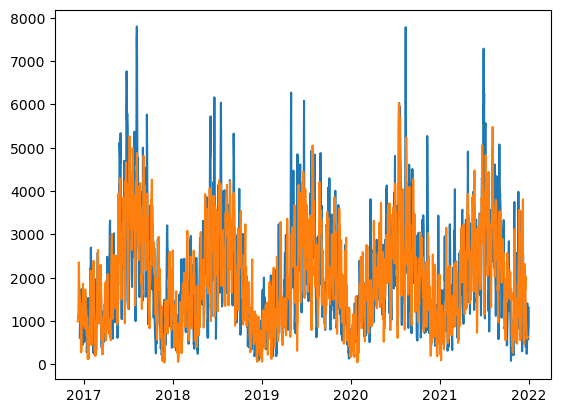

In [14]:
PRtoadm_ros_sh = shift_time(PRtoadm_ros,age_2018['forpr_ros3'][2],datelist_vs,base_adm[0],factor_adm[0])
PRtoadm_rosb_sh = shift_time(PRtoadm_rosb,age_2018['backadm_ros3'][4],datelist_vs,-base_adm[0],-factor_adm[0])

PRtoadm_ros_m,PRtoadm_rosb_m,c,PRtoadm_ros_avg = merge(PRtoadm_ros_sh,PRtoadm_rosb_sh)
print(c)

plt.plot(PRtoadm_ros_m.Transport)
plt.plot(PRtoadm_rosb_m.Transport)

### Split into single years

#### Only 2017

-1.0 0.15000000000000102 0.6822607053092881
-1.0 0.20000000000000107 0.7024470443652207
-1.0 0.2500000000000011 0.6527367718418796
-0.95 0.15000000000000102 0.6815343528077523
-0.95 0.20000000000000107 0.7021170463876445
-0.95 0.2500000000000011 0.650945497492129
-0.95 0.9500000000000017 0.6510911090813857


-0.8999999999999999 0.15000000000000102 0.6942969499898561
-0.8999999999999999 0.20000000000000107 0.6996713995571741
-0.8999999999999999 0.9500000000000017 0.6543688347800473
-0.8499999999999999 0.15000000000000102 0.6942181648274368
-0.8499999999999999 0.20000000000000107 0.6970079666614348
-0.8499999999999999 0.9500000000000017 0.6504381551130786
-0.7999999999999998 0.15000000000000102 0.6907577733506078
-0.7999999999999998 0.20000000000000107 0.6965526602468409
-0.7499999999999998 0.15000000000000102 0.6890934323506804
-0.7499999999999998 0.20000000000000107 0.6982884658800252
-0.7499999999999998 0.9500000000000017 0.6618792344362406
-0.6999999999999997 0.15000000000000102 0.6875685515573651
-0.6999999999999997 0.20000000000000107 0.6935700703229921
-0.6999999999999997 0.9500000000000017 0.6603040878574578
-0.6499999999999997 0.15000000000000102 0.6943345937185988
-0.6499999999999997 0.20000000000000107 0.6922200693702013
-0.6499999999999997 0.9500000000000017 0.6547876500823443
-0

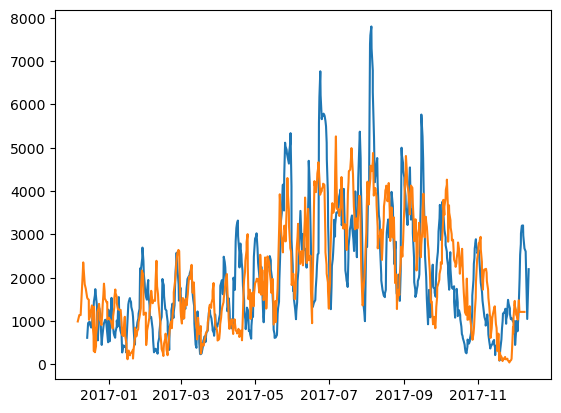

In [15]:
PRtoadm2017_rosl = sectransp_2018['forpr_ros3'][2][0:365]
PRtoadm2017_rosbl = sectransp_2018['backadm_ros3'][4][0:365]

PRtoadm2017_ros = pd.Series(PRtoadm2017_rosl,index=datelist_vs[0:365])
PRtoadm2017_rosb = pd.Series(PRtoadm2017_rosbl,index=datelist_vs[0:365])

# Loop through different base and factors to find which combination maximizes the correlation

factor_arr = np.arange(-1,1,0.05)
base_arr = np.arange(-1,1,0.05)

corr_arr = np.zeros([len(base_arr),len(factor_arr)])

for i,base in enumerate(base_arr):
    for j,factor in enumerate(factor_arr):
        dfr1 = shift_time(PRtoadm2017_ros,age_2018['forpr_ros3'][2][0:365],datelist_vs[0:365],base,factor)
        dfr2 = shift_time(PRtoadm2017_rosb,age_2018['backadm_ros3'][4][0:365],datelist_vs[0:365],-base,-factor)
        dfr1_sh,dfr2_sh,corr_arr[i,j],a = merge(dfr1,dfr2)
        if corr_arr[i,j] > 0.65:
            print (base, factor, corr_arr[i, j])
            
i_base_adm,i_factor_adm = np.where(corr_arr==np.max(corr_arr))

base_adm = base_arr[i_base_adm]
factor_adm = factor_arr[i_factor_adm]

print(base_adm,factor_adm)

PRtoadm2017_ros_sh = shift_time(PRtoadm2017_ros,age_2018['forpr_ros3'][2][0:365],datelist_vs[0:365],base_adm[0],factor_adm[0])
PRtoadm2017_rosb_sh = shift_time(PRtoadm2017_rosb,age_2018['backadm_ros3'][4][0:365],datelist_vs[0:365],-base_adm[0],-factor_adm[0])

PRtoadm2017_ros_m,PRtoadm2017_rosb_m,c,PRtoadm2017_ros_avg = merge(PRtoadm2017_ros_sh,PRtoadm2017_rosb_sh)
print(c)

plt.plot(PRtoadm2017_ros_m.Transport)
plt.plot(PRtoadm2017_rosb_m.Transport)

#### Now do this same for only 2018

In [16]:
PRtoadm2018_rosl = sectransp_2018['forpr_ros3'][2][365:750]
PRtoadm2018_rosbl = sectransp_2018['backadm_ros3'][4][365:750]

PRtoadm2018_ros = pd.Series(PRtoadm2018_rosl,index=datelist_vs[365:750])
PRtoadm2018_rosb = pd.Series(PRtoadm2018_rosbl,index=datelist_vs[365:750])

In [17]:
# Loop through different base and factors to find which combination maximizes the correlation

factor_arr = np.arange(-1,1,0.05)
base_arr = np.arange(-1,1,0.05)

corr_arr = np.zeros([len(base_arr),len(factor_arr)])

for i,base in enumerate(base_arr):
    for j,factor in enumerate(factor_arr):
        dfr1 = shift_time(PRtoadm2018_ros,age_2018['forpr_ros3'][2][365:750],datelist_vs[365:750],base,factor)
        dfr2 = shift_time(PRtoadm2018_rosb,age_2018['backadm_ros3'][4][365:750],datelist_vs[365:750],-base,-factor)
        dfr1_sh,dfr2_sh,corr_arr[i,j],a = merge(dfr1,dfr2)
        if corr_arr[i,j] > 0.8:
            print (base, factor, corr_arr[i, j])

In [18]:
i_base_adm,i_factor_adm = np.where(corr_arr==np.max(corr_arr))

base_adm = base_arr[i_base_adm]
factor_adm = factor_arr[i_factor_adm]

print(base_adm,factor_adm)

[-0.8] [0.15]


0.6550074656313384


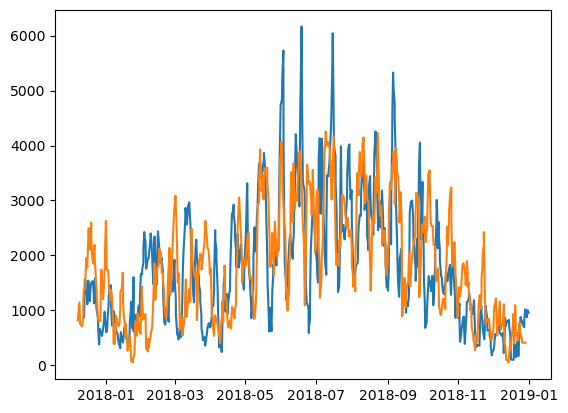

In [19]:
PRtoadm2018_ros_sh = shift_time(PRtoadm2018_ros,age_2018['forpr_ros3'][2][365:750],datelist_vs[365:750],base_adm[0],factor_adm[0])
PRtoadm2018_rosb_sh = shift_time(PRtoadm2018_rosb,age_2018['backadm_ros3'][4][365:750],datelist_vs[365:750],-base_adm[0],-factor_adm[0])

PRtoadm2018_ros_m,PRtoadm2018_rosb_m,c,PRtoadm2018_ros_avg = merge(PRtoadm2018_ros_sh,PRtoadm2018_rosb_sh)
print(c)

plt.plot(PRtoadm2018_ros_m.Transport)
plt.plot(PRtoadm2018_rosb_m.Transport)

#### Now do this for only 2019

In [20]:
PRtoadm2019_rosl = sectransp_2018['forpr_ros3'][2][750:1110]
PRtoadm2019_rosbl = sectransp_2018['backadm_ros3'][4][750:1110]

PRtoadm2019_ros = pd.Series(PRtoadm2019_rosl,index=datelist_vs[750:1110])
PRtoadm2019_rosb = pd.Series(PRtoadm2019_rosbl,index=datelist_vs[750:1110])

In [21]:
# Loop through different base and factors to find which combination maximizes the correlation

factor_arr = np.arange(-1,1,0.05)
base_arr = np.arange(-1,1,0.05)

corr_arr = np.zeros([len(base_arr),len(factor_arr)])

for i,base in enumerate(base_arr):
    for j,factor in enumerate(factor_arr):
        dfr1 = shift_time(PRtoadm2019_ros,age_2018['forpr_ros3'][2][750:1110],datelist_vs[750:1110],base,factor)
        dfr2 = shift_time(PRtoadm2019_rosb,age_2018['backadm_ros3'][4][750:1110],datelist_vs[750:1110],-base,-factor)
        dfr1_sh,dfr2_sh,corr_arr[i,j],a = merge(dfr1,dfr2)
        if corr_arr[i,j] > 0.57:
            print (base, factor, corr_arr[i, j])

-1.0 0.3500000000000012 0.5762973272730353
-0.95 0.3500000000000012 0.5772148908053214
-0.95 0.40000000000000124 0.5711493272782864
-0.8999999999999999 0.3500000000000012 0.5777127981753594
-0.8499999999999999 0.3500000000000012 0.5717322542979335
-0.7499999999999998 0.3500000000000012 0.5758560027660321
-0.6999999999999997 0.3500000000000012 0.5708110013816076
-0.6499999999999997 0.3500000000000012 0.5768378802871007
-0.5999999999999996 0.3500000000000012 0.570875670845368
-0.49999999999999956 0.3500000000000012 0.5749281616465954
-0.4499999999999995 0.3500000000000012 0.579613943595951
-0.39999999999999947 0.3500000000000012 0.5738270850140776
-0.3499999999999994 0.3500000000000012 0.5778686135893547
-0.2999999999999994 0.3500000000000012 0.5788510131111585
-0.24999999999999933 0.3500000000000012 0.5758464559731834
-0.1999999999999993 0.30000000000000115 0.5704286483682088
-0.1999999999999993 0.3500000000000012 0.5730421755092
-0.14999999999999925 0.30000000000000115 0.57319592051076

In [22]:
i_base_adm,i_factor_adm = np.where(corr_arr==np.max(corr_arr))

base_adm = base_arr[i_base_adm]
factor_adm = factor_arr[i_factor_adm]

print(base_adm,factor_adm)

[0.55] [0.3]


0.585937588817407


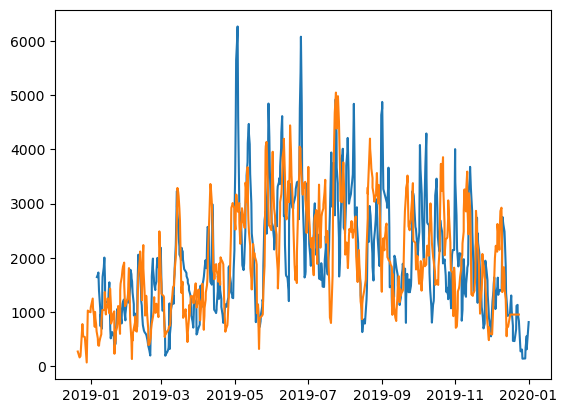

In [23]:
PRtoadm2019_ros_sh = shift_time(PRtoadm2019_ros,age_2018['forpr_ros3'][2][750:1110],datelist_vs[750:1110],base_adm[0],factor_adm[0])
PRtoadm2019_rosb_sh = shift_time(PRtoadm2019_rosb,age_2018['backadm_ros3'][4][750:1110],datelist_vs[750:1110],-base_adm[0],-factor_adm[0])

PRtoadm2019_ros_m,PRtoadm2019_rosb_m,c,PRtoadm2019_ros_avg = merge(PRtoadm2019_ros_sh,PRtoadm2019_rosb_sh)
print(c)

plt.plot(PRtoadm2019_ros_m.Transport)
plt.plot(PRtoadm2019_rosb_m.Transport)

#### Now for 2020

In [24]:
PRtoadm2020_rosl = sectransp_2018['forpr_ros3'][2][1110:1460]
PRtoadm2020_rosbl = sectransp_2018['backadm_ros3'][4][1110:1460]

PRtoadm2020_ros = pd.Series(PRtoadm2020_rosl,index=datelist_vs[1110:1460])
PRtoadm2020_rosb = pd.Series(PRtoadm2020_rosbl,index=datelist_vs[1110:1460])

# Loop through different base and factors to find which combination maximizes the correlation

factor_arr = np.arange(-1,1,0.05)
base_arr = np.arange(-1,1,0.05)

corr_arr = np.zeros([len(base_arr),len(factor_arr)])

for i,base in enumerate(base_arr):
    for j,factor in enumerate(factor_arr):
        dfr1 = shift_time(PRtoadm2020_ros,age_2018['forpr_ros3'][2][1110:1460],datelist_vs[1110:1460],base,factor)
        dfr2 = shift_time(PRtoadm2020_rosb,age_2018['backadm_ros3'][4][1110:1460],datelist_vs[1110:1460],-base,-factor)
        dfr1_sh,dfr2_sh,corr_arr[i,j],a = merge(dfr1,dfr2)
        if corr_arr[i,j] > 0.57:
            print (base, factor, corr_arr[i, j])
            
i_base_adm,i_factor_adm = np.where(corr_arr==np.max(corr_arr))

base_adm = base_arr[i_base_adm]
factor_adm = factor_arr[i_factor_adm]

print(base_adm,factor_adm)

-1.0 0.20000000000000107 0.6209366878136215
-1.0 0.2500000000000011 0.6603419037308395
-1.0 0.30000000000000115 0.6506753008996614
-1.0 0.3500000000000012 0.5987796774813878
-1.0 0.40000000000000124 0.5706705668893272
-0.95 0.20000000000000107 0.6270608267971052
-0.95 0.2500000000000011 0.6483629464328978
-0.95 0.30000000000000115 0.646469131980799
-0.95 0.3500000000000012 0.5952257255738935
-0.8999999999999999 0.20000000000000107 0.6310598446377154
-0.8999999999999999 0.2500000000000011 0.6498182448550357
-0.8999999999999999 0.30000000000000115 0.6406121296592753
-0.8999999999999999 0.3500000000000012 0.5999334753115627
-0.8499999999999999 0.20000000000000107 0.6268682661903421
-0.8499999999999999 0.2500000000000011 0.643134145167998
-0.8499999999999999 0.30000000000000115 0.6362855282202504
-0.8499999999999999 0.3500000000000012 0.5981421255925088
-0.7999999999999998 0.20000000000000107 0.6383125113374131
-0.7999999999999998 0.2500000000000011 0.6487446449236278
-0.7999999999999998 0

0.6808523830688374


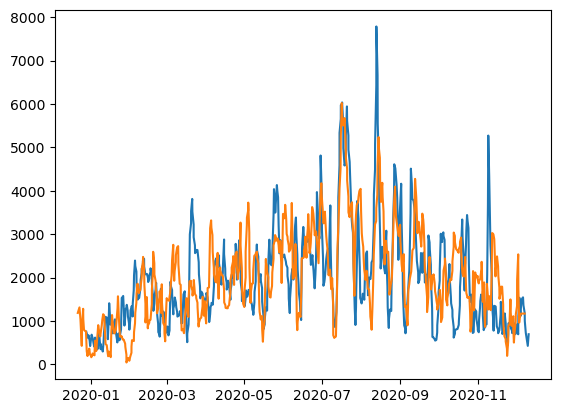

In [25]:
PRtoadm2020_ros_sh = shift_time(PRtoadm2020_ros,age_2018['forpr_ros3'][2][1110:1460],datelist_vs[1110:1460],base_adm[0],factor_adm[0])
PRtoadm2020_rosb_sh = shift_time(PRtoadm2020_rosb,age_2018['backadm_ros3'][4][1110:1460],datelist_vs[1110:1460],-base_adm[0],-factor_adm[0])

PRtoadm2020_ros_m,PRtoadm2020_rosb_m,c,PRtoadm2020_ros_avg = merge(PRtoadm2020_ros_sh,PRtoadm2020_rosb_sh)
print(c)

plt.plot(PRtoadm2020_ros_m.Transport)
plt.plot(PRtoadm2020_rosb_m.Transport)

#### Now for 2021

In [26]:
PRtoadm2021_rosl = sectransp_2018['forpr_ros3'][2][1460:]
PRtoadm2021_rosbl = sectransp_2018['backadm_ros3'][4][1460:]

PRtoadm2021_ros = pd.Series(PRtoadm2021_rosl,index=datelist_vs[1460:])
PRtoadm2021_rosb = pd.Series(PRtoadm2021_rosbl,index=datelist_vs[1460:])

# Loop through different base and factors to find which combination maximizes the correlation

factor_arr = np.arange(-1,1,0.05)
base_arr = np.arange(-1,1,0.05)

corr_arr = np.zeros([len(base_arr),len(factor_arr)])

for i,base in enumerate(base_arr):
    for j,factor in enumerate(factor_arr):
        dfr1 = shift_time(PRtoadm2021_ros,age_2018['forpr_ros3'][2][1460:],datelist_vs[1460:],base,factor)
        dfr2 = shift_time(PRtoadm2021_rosb,age_2018['backadm_ros3'][4][1460:],datelist_vs[1460:],-base,-factor)
        dfr1_sh,dfr2_sh,corr_arr[i,j],a = merge(dfr1,dfr2)
        if corr_arr[i,j] > 0.57:
            print (base, factor, corr_arr[i, j])
            
i_base_adm,i_factor_adm = np.where(corr_arr==np.max(corr_arr))

base_adm = base_arr[i_base_adm]
factor_adm = factor_arr[i_factor_adm]

print(base_adm,factor_adm)

-1.0 0.20000000000000107 0.5729763819284602
-0.95 0.20000000000000107 0.5799883611944041
-0.8999999999999999 0.15000000000000102 0.5709275022174856
-0.8999999999999999 0.20000000000000107 0.5838827625420333
-0.8499999999999999 0.15000000000000102 0.5760436113006984
-0.8499999999999999 0.20000000000000107 0.5926740794875357
-0.7999999999999998 0.15000000000000102 0.5721840263938961
-0.7999999999999998 0.20000000000000107 0.5940202998606867
-0.7499999999999998 0.20000000000000107 0.5825203536847657
-0.6999999999999997 0.20000000000000107 0.5793864448343177
-0.6499999999999997 0.15000000000000102 0.571783048061966
-0.6499999999999997 0.20000000000000107 0.5786549080110281
-0.5999999999999996 0.15000000000000102 0.5708992650753353
-0.5999999999999996 0.20000000000000107 0.5709602073570669
-0.3499999999999994 0.15000000000000102 0.5736169583149043
-0.2999999999999994 0.15000000000000102 0.5790558315472552
-0.24999999999999933 0.15000000000000102 0.5820032352776671
-0.1999999999999993 0.1500

0.5983610391386281


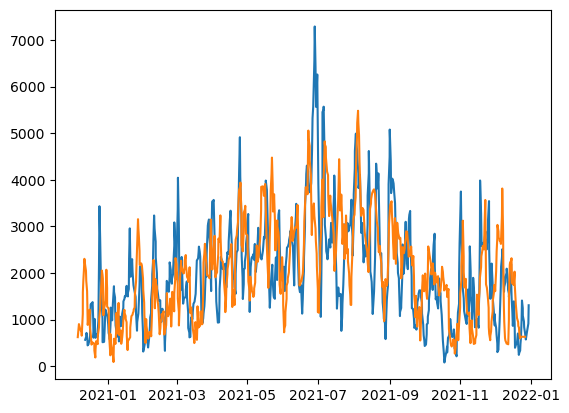

In [27]:
PRtoadm2021_ros_sh = shift_time(PRtoadm2021_ros,age_2018['forpr_ros3'][2][1460:],datelist_vs[1460:],base_adm[0],factor_adm[0])
PRtoadm2021_rosb_sh = shift_time(PRtoadm2021_rosb,age_2018['backadm_ros3'][4][1460:],datelist_vs[1460:],-base_adm[0],-factor_adm[0])

PRtoadm2021_ros_m,PRtoadm2021_rosb_m,c,PRtoadm2021_ros_avg = merge(PRtoadm2021_ros_sh,PRtoadm2021_rosb_sh)
print(c)

plt.plot(PRtoadm2021_ros_m.Transport)
plt.plot(PRtoadm2021_rosb_m.Transport)

### PR to VicSill

In [28]:
PRtovs_rosl = sectransp_2018['forpr_ros3'][4]
PRtovs_rosbl = sectransp_2018['backvs_ros3'][4]

PRtovs_ros = pd.Series(PRtovs_rosl,index=datelist_vs)
PRtovs_rosb = pd.Series(PRtovs_rosbl,index=datelist_vs)

In [29]:
# Loop through different base and factors to find which combination maximizes the correlation

factor_arr = np.arange(-1,1,0.05)
base_arr = np.arange(-1,1,0.05)

corr_arr = np.zeros([len(base_arr),len(factor_arr)])

for i,base in enumerate(base_arr):
    for j,factor in enumerate(factor_arr):
        dfr1 = shift_time(PRtovs_ros,age_2018['forpr_ros3'][4],datelist_vs,base,factor)
        dfr2 = shift_time(PRtovs_rosb,age_2018['backvs_ros3'][4],datelist_vs,-base,-factor)
        dfr1_sh,dfr2_sh,corr_arr[i,j],a = merge(dfr1,dfr2)
        if corr_arr[i,j] > 0.68:
            print (base, factor, corr_arr[i, j])

-1.0 0.2500000000000011 0.7325336247425104
-1.0 0.30000000000000115 0.7179785434184929
-0.95 0.2500000000000011 0.7310162412347257
-0.95 0.30000000000000115 0.7103502039954206
-0.8999999999999999 0.20000000000000107 0.6838486549566245
-0.8999999999999999 0.2500000000000011 0.7310166769936179
-0.8999999999999999 0.30000000000000115 0.7061260427139905
-0.8499999999999999 0.20000000000000107 0.6893627421980109
-0.8499999999999999 0.2500000000000011 0.7291223295972036
-0.8499999999999999 0.30000000000000115 0.7040888935453391
-0.7999999999999998 0.20000000000000107 0.6936035140457749
-0.7999999999999998 0.2500000000000011 0.7320561670492404
-0.7999999999999998 0.30000000000000115 0.7027620914408726
-0.7499999999999998 0.20000000000000107 0.6972364300202912
-0.7499999999999998 0.2500000000000011 0.7344922554226359
-0.7499999999999998 0.30000000000000115 0.6964307996002491
-0.6999999999999997 0.20000000000000107 0.6979842814440604
-0.6999999999999997 0.2500000000000011 0.7322324237547829
-0.

0.6000000000000014 0.15000000000000102 0.7152139105812118
0.6000000000000014 0.20000000000000107 0.7061567638316034
0.6500000000000015 0.15000000000000102 0.716255068402869
0.6500000000000015 0.20000000000000107 0.7021538882085243
0.7000000000000015 0.15000000000000102 0.7146966293927175
0.7000000000000015 0.20000000000000107 0.69815315448332
0.7500000000000016 0.15000000000000102 0.7153894748729244
0.7500000000000016 0.20000000000000107 0.6963356410962004
0.8000000000000016 0.15000000000000102 0.7183714639332015
0.8000000000000016 0.20000000000000107 0.6946231937908636
0.8500000000000016 0.15000000000000102 0.718503511153968
0.8500000000000016 0.20000000000000107 0.6863819790159288
0.9000000000000017 0.15000000000000102 0.7192940613349493
0.9000000000000017 0.20000000000000107 0.6848046488243436
0.9500000000000017 0.15000000000000102 0.7170428313733768


In [30]:
i_base_adm,i_factor_adm = np.where(corr_arr==np.max(corr_arr))

base_adm = base_arr[i_base_adm]
factor_adm = factor_arr[i_factor_adm]

print(base_adm,factor_adm)

[-0.75] [0.25]


0.7344922554226359


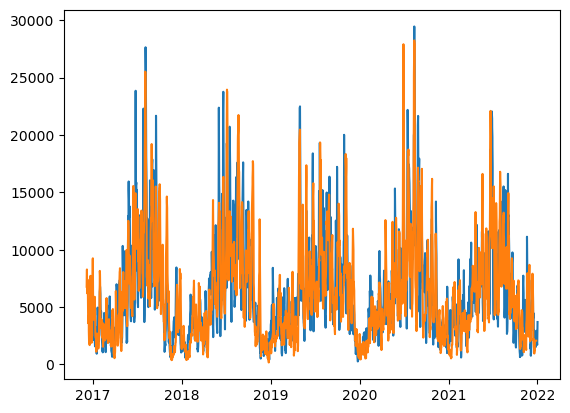

In [31]:
PRtovs_ros_sh = shift_time(PRtovs_ros,age_2018['forpr_ros3'][4],datelist_vs,base_adm[0],factor_adm[0])
PRtovs_rosb_sh = shift_time(PRtovs_rosb,age_2018['backvs_ros3'][4],datelist_vs,-base_adm[0],-factor_adm[0])

PRtovs_ros_m,PRtovs_rosb_m,c,PRtovs_ros_avg = merge(PRtovs_ros_sh,PRtovs_rosb_sh)
print(c)

plt.plot(PRtovs_ros_m.Transport)
plt.plot(PRtovs_rosb_m.Transport)

### Split into years

### 2017

-1.0 0.20000000000000107 0.7610843511718882
-1.0 0.2500000000000011 0.7763198426842873
-0.95 0.20000000000000107 0.7615233814859687
-0.95 0.2500000000000011 0.7630359475334424
-0.8999999999999999 0.20000000000000107 0.7648934420523167
-0.8999999999999999 0.2500000000000011 0.758683328570182
-0.8499999999999999 0.20000000000000107 0.7628555302688944
-0.8499999999999999 0.2500000000000011 0.7541300583776663
-0.7999999999999998 0.20000000000000107 0.7582768697304704
-0.7999999999999998 0.2500000000000011 0.7523415587675286
-0.7499999999999998 0.20000000000000107 0.7555752947107308
-0.7499999999999998 0.2500000000000011 0.7507323016133077
-0.6999999999999997 0.20000000000000107 0.7510759894839689
-0.6999999999999997 0.2500000000000011 0.7443611153684692
-0.6499999999999997 0.20000000000000107 0.7624439880334823
-0.6499999999999997 0.2500000000000011 0.7449211531184489
-0.5999999999999996 0.20000000000000107 0.7717712498882352
-0.5999999999999996 0.2500000000000011 0.741380026546958
-0.5499

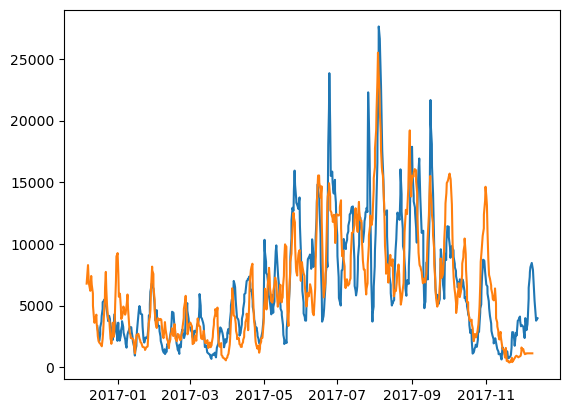

In [32]:
PRtovs2017_rosl = sectransp_2018['forpr_ros3'][4][0:365]
PRtovs2017_rosbl = sectransp_2018['backvs_ros3'][4][0:365]

PRtovs2017_ros = pd.Series(PRtovs2017_rosl,index=datelist_vs[0:365])
PRtovs2017_rosb = pd.Series(PRtovs2017_rosbl,index=datelist_vs[0:365])

# Loop through different base and factors to find which combination maximizes the correlation

factor_arr = np.arange(-1,1,0.05)
base_arr = np.arange(-1,1,0.05)

corr_arr = np.zeros([len(base_arr),len(factor_arr)])

for i,base in enumerate(base_arr):
    for j,factor in enumerate(factor_arr):
        dfr1 = shift_time(PRtovs2017_ros,age_2018['forpr_ros3'][4][0:365],datelist_vs[0:365],base,factor)
        dfr2 = shift_time(PRtovs2017_rosb,age_2018['backvs_ros3'][4][0:365],datelist_vs[0:365],-base,-factor)
        dfr1_sh,dfr2_sh,corr_arr[i,j],a = merge(dfr1,dfr2)
        if corr_arr[i,j] > 0.73:
            print (base, factor, corr_arr[i, j])
            
i_base_adm,i_factor_adm = np.where(corr_arr==np.max(corr_arr))

base_adm = base_arr[i_base_adm]
factor_adm = factor_arr[i_factor_adm]

print(base_adm,factor_adm)

PRtovs2017_ros_sh = shift_time(PRtovs2017_ros,age_2018['forpr_ros3'][4][0:365],datelist_vs[0:365],base_adm[0],factor_adm[0])
PRtovs2017_rosb_sh = shift_time(PRtovs2017_rosb,age_2018['backvs_ros3'][4][0:365],datelist_vs[0:365],-base_adm[0],-factor_adm[0])

PRtovs2017_ros_m,PRtovs2017_rosb_m,c,PRtovs2017_ros_avg = merge(PRtovs2017_ros_sh,PRtovs2017_rosb_sh)
print(c)

plt.plot(PRtovs2017_ros_m.Transport)
plt.plot(PRtovs2017_rosb_m.Transport)

#### Now do this for only 2018

In [33]:
PRtovs2018_rosl = sectransp_2018['forpr_ros3'][4][365:750]
PRtovs2018_rosbl = sectransp_2018['backvs_ros3'][4][365:750]

PRtovs2018_ros = pd.Series(PRtovs2018_rosl,index=datelist_vs[365:750])
PRtovs2018_rosb = pd.Series(PRtovs2018_rosbl,index=datelist_vs[365:750])

In [34]:
# Loop through different base and factors to find which combination maximizes the correlation

factor_arr = np.arange(-1,1,0.05)
base_arr = np.arange(-1,1,0.05)

corr_arr = np.zeros([len(base_arr),len(factor_arr)])

for i,base in enumerate(base_arr):
    for j,factor in enumerate(factor_arr):
        dfr1 = shift_time(PRtovs2018_ros,age_2018['forpr_ros3'][4][365:750],datelist_vs[365:750],base,factor)
        dfr2 = shift_time(PRtovs2018_rosb,age_2018['backvs_ros3'][4][365:750],datelist_vs[365:750],-base,-factor)
        dfr1_sh,dfr2_sh,corr_arr[i,j],a = merge(dfr1,dfr2)
        if corr_arr[i,j] > 0.73:
            print (base, factor, corr_arr[i, j])

-1.0 0.30000000000000115 0.7383132790320881
-0.7499999999999998 0.2500000000000011 0.7303184671278201
-0.6499999999999997 0.2500000000000011 0.7314656453815972
-0.5999999999999996 0.2500000000000011 0.7307758320789479
-0.39999999999999947 0.2500000000000011 0.730445030017987
-0.3499999999999994 0.2500000000000011 0.7342245171321492
0.15000000000000102 0.20000000000000107 0.7317687809152374
0.20000000000000107 0.20000000000000107 0.7339911066854953


In [35]:
i_base_adm,i_factor_adm = np.where(corr_arr==np.max(corr_arr))

base_adm = base_arr[i_base_adm]
factor_adm = factor_arr[i_factor_adm]

print(base_adm,factor_adm)

[-1.] [0.3]


0.7383132790320881


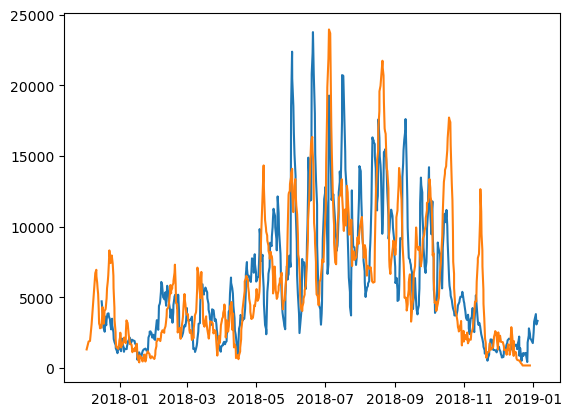

In [36]:
PRtovs2018_ros_sh = shift_time(PRtovs2018_ros,age_2018['forpr_ros3'][4][365:750],datelist_vs[365:750],base_adm[0],factor_adm[0])
PRtovs2018_rosb_sh = shift_time(PRtovs2018_rosb,age_2018['backvs_ros3'][4][365:750],datelist_vs[365:750],-base_adm[0],-factor_adm[0])

PRtovs2018_ros_m,PRtovs2018_rosb_m,c,PRtovs2018_ros_avg = merge(PRtovs2018_ros_sh,PRtovs2018_rosb_sh)
print(c)

plt.plot(PRtovs2018_ros_m.Transport)
plt.plot(PRtovs2018_rosb_m.Transport)

#### Now do this for 2019

In [37]:
PRtovs2019_rosl = sectransp_2018['forpr_ros3'][4][750:1110]
PRtovs2019_rosbl = sectransp_2018['backvs_ros3'][4][750:1110]

PRtovs2019_ros = pd.Series(PRtovs2019_rosl,index=datelist_vs[750:1110])
PRtovs2019_rosb = pd.Series(PRtovs2019_rosbl,index=datelist_vs[750:1110])

In [38]:
# Loop through different base and factors to find which combination maximizes the correlation

factor_arr = np.arange(-1,1,0.05)
base_arr = np.arange(-1,1,0.05)

corr_arr = np.zeros([len(base_arr),len(factor_arr)])

for i,base in enumerate(base_arr):
    for j,factor in enumerate(factor_arr):
        dfr1 = shift_time(PRtovs2019_ros,age_2018['forpr_ros3'][4][750:1110],datelist_vs[750:1110],base,factor)
        dfr2 = shift_time(PRtovs2019_rosb,age_2018['backvs_ros3'][4][750:1110],datelist_vs[750:1110],-base,-factor)
        dfr1_sh,dfr2_sh,corr_arr[i,j],a = merge(dfr1,dfr2)
        if corr_arr[i,j] > 0.57:
            print (base, factor, corr_arr[i, j])

-1.0 0.30000000000000115 0.6075211384337889
-0.95 0.30000000000000115 0.5934285748119174
-0.8999999999999999 0.30000000000000115 0.5876971535653234
-0.8499999999999999 0.2500000000000011 0.5715248251737987
-0.8499999999999999 0.30000000000000115 0.5889254336422473
-0.7999999999999998 0.2500000000000011 0.5838706505899163
-0.7999999999999998 0.30000000000000115 0.5860876576449532
-0.7499999999999998 0.2500000000000011 0.5881843768809776
-0.7499999999999998 0.30000000000000115 0.5763112030109387
-0.6999999999999997 0.2500000000000011 0.5905018505811089
-0.6999999999999997 0.30000000000000115 0.5745533726522075
-0.6499999999999997 0.2500000000000011 0.5917824028232308
-0.6499999999999997 0.30000000000000115 0.5776125998124596
-0.5999999999999996 0.2500000000000011 0.5925020515621047
-0.5999999999999996 0.30000000000000115 0.5803866724311335
-0.5499999999999996 0.2500000000000011 0.5914653219695614
-0.49999999999999956 0.2500000000000011 0.60028901117714
-0.4499999999999995 0.2500000000000

In [39]:
i_base_adm,i_factor_adm = np.where(corr_arr==np.max(corr_arr))

base_adm = base_arr[i_base_adm]
factor_adm = factor_arr[i_factor_adm]

print(base_adm,factor_adm)

[-1.] [0.3]


0.6075211384337889


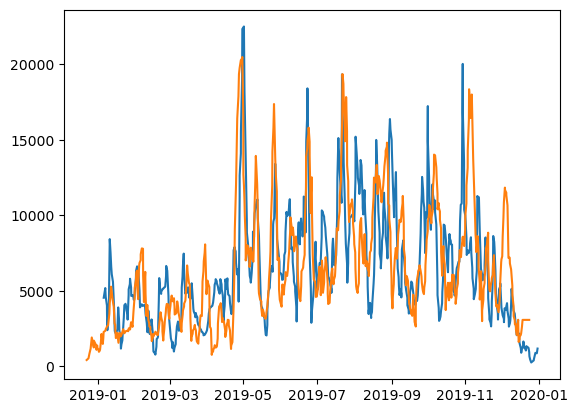

In [40]:
PRtovs2019_ros_sh = shift_time(PRtovs2019_ros,age_2018['forpr_ros3'][4][750:1110],datelist_vs[750:1110],base_adm[0],factor_adm[0])
PRtovs2019_rosb_sh = shift_time(PRtovs2019_rosb,age_2018['backvs_ros3'][4][750:1110],datelist_vs[750:1110],-base_adm[0],-factor_adm[0])

PRtovs2019_ros_m,PRtovs2019_rosb_m,c,PRtovs2019_ros_avg = merge(PRtovs2019_ros_sh,PRtovs2019_rosb_sh)
print(c)

plt.plot(PRtovs2019_ros_m.Transport)
plt.plot(PRtovs2019_rosb_m.Transport)

#### Now this for 2020

In [41]:
PRtovs2020_rosl = sectransp_2018['forpr_ros3'][4][1110:1460]
PRtovs2020_rosbl = sectransp_2018['backvs_ros3'][4][1110:1460]

PRtovs2020_ros = pd.Series(PRtovs2020_rosl,index=datelist_vs[1110:1460])
PRtovs2020_rosb = pd.Series(PRtovs2020_rosbl,index=datelist_vs[1110:1460])

# Loop through different base and factors to find which combination maximizes the correlation

factor_arr = np.arange(-1,1,0.05)
base_arr = np.arange(-1,1,0.05)

corr_arr = np.zeros([len(base_arr),len(factor_arr)])

for i,base in enumerate(base_arr):
    for j,factor in enumerate(factor_arr):
        dfr1 = shift_time(PRtovs2020_ros,age_2018['forpr_ros3'][4][1110:1460],datelist_vs[1110:1460],base,factor)
        dfr2 = shift_time(PRtovs2020_rosb,age_2018['backvs_ros3'][4][1110:1460],datelist_vs[1110:1460],-base,-factor)
        dfr1_sh,dfr2_sh,corr_arr[i,j],a = merge(dfr1,dfr2)
        if corr_arr[i,j] > 0.57:
            print (base, factor, corr_arr[i, j])
            
i_base_adm,i_factor_adm = np.where(corr_arr==np.max(corr_arr))

base_adm = base_arr[i_base_adm]
factor_adm = factor_arr[i_factor_adm]

print(base_adm,factor_adm)

-1.0 0.15000000000000102 0.5777372008991812
-1.0 0.20000000000000107 0.7235128021885254
-1.0 0.2500000000000011 0.8179089506000462
-1.0 0.30000000000000115 0.7909405145146315
-1.0 0.3500000000000012 0.6719771739841168
-0.95 0.15000000000000102 0.5777823554010787
-0.95 0.20000000000000107 0.7375340915786697
-0.95 0.2500000000000011 0.8184372337250301
-0.95 0.30000000000000115 0.786491465703274
-0.95 0.3500000000000012 0.6734633970430354
-0.8999999999999999 0.15000000000000102 0.5787356048095568
-0.8999999999999999 0.20000000000000107 0.7451338022394541
-0.8999999999999999 0.2500000000000011 0.8202240288090273
-0.8999999999999999 0.30000000000000115 0.7826189888483195
-0.8999999999999999 0.3500000000000012 0.6681729009386236
-0.8499999999999999 0.15000000000000102 0.5942466286999506
-0.8499999999999999 0.20000000000000107 0.7522822875244594
-0.8499999999999999 0.2500000000000011 0.819421588915242
-0.8499999999999999 0.30000000000000115 0.7776565147506596
-0.8499999999999999 0.35000000000

0.8240852710771298


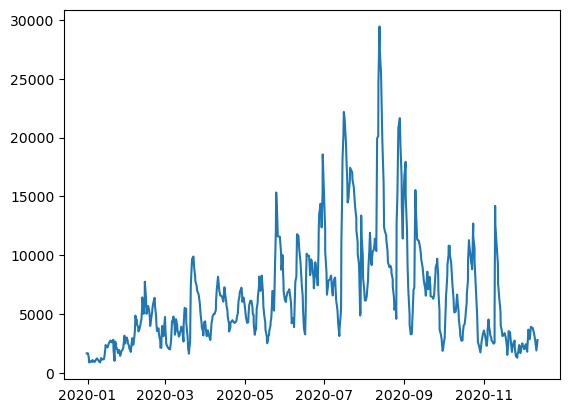

In [42]:
PRtovs2020_ros_sh = shift_time(PRtovs2020_ros,age_2018['forpr_ros3'][4][1110:1460],datelist_vs[1110:1460],base_adm[0],factor_adm[0])
PRtovs2020_rosb_sh = shift_time(PRtovs2020_rosb,age_2018['backvs_ros3'][4][1110:1460],datelist_vs[1110:1460],-base_adm[0],-factor_adm[0])

PRtovs2020_ros_m,PRtovs2020_rosb_m,c,PRtovs2020_ros_avg = merge(PRtovs2020_ros_sh,PRtovs2020_rosb_sh)
print(c)

plt.plot(PRtovs2020_ros_m.Transport)

#### Now for 2021

In [43]:
PRtovs2021_rosl = sectransp_2018['forpr_ros3'][4][1460:]
PRtovs2021_rosbl = sectransp_2018['backvs_ros3'][4][1460:]

PRtovs2021_ros = pd.Series(PRtovs2021_rosl,index=datelist_vs[1460:])
PRtovs2021_rosb = pd.Series(PRtovs2021_rosbl,index=datelist_vs[1460:])

# Loop through different base and factors to find which combination maximizes the correlation

factor_arr = np.arange(-1,1,0.05)
base_arr = np.arange(-1,1,0.05)

corr_arr = np.zeros([len(base_arr),len(factor_arr)])

for i,base in enumerate(base_arr):
    for j,factor in enumerate(factor_arr):
        dfr1 = shift_time(PRtovs2021_ros,age_2018['forpr_ros3'][4][1460:],datelist_vs[1460:],base,factor)
        dfr2 = shift_time(PRtovs2021_rosb,age_2018['backvs_ros3'][4][1460:],datelist_vs[1460:],-base,-factor)
        dfr1_sh,dfr2_sh,corr_arr[i,j],a = merge(dfr1,dfr2)
        if corr_arr[i,j] > 0.57:
            print (base, factor, corr_arr[i, j])
            
i_base_adm,i_factor_adm = np.where(corr_arr==np.max(corr_arr))

base_adm = base_arr[i_base_adm]
factor_adm = factor_arr[i_factor_adm]

print(base_adm,factor_adm)

-1.0 0.15000000000000102 0.5746431334328468
-1.0 0.20000000000000107 0.6588634608325544
-1.0 0.2500000000000011 0.6987159890164342
-1.0 0.30000000000000115 0.6927351707953536
-1.0 0.3500000000000012 0.6280027152299006
-0.95 0.15000000000000102 0.580675311420146
-0.95 0.20000000000000107 0.6561114586429424
-0.95 0.2500000000000011 0.7013669316289
-0.95 0.30000000000000115 0.6877956954337254
-0.95 0.3500000000000012 0.6318229646626421
-0.8999999999999999 0.15000000000000102 0.5966212787720768
-0.8999999999999999 0.20000000000000107 0.6537619611705109
-0.8999999999999999 0.2500000000000011 0.7041142268384987
-0.8999999999999999 0.30000000000000115 0.6802387962689193
-0.8999999999999999 0.3500000000000012 0.6402407795152583
-0.8499999999999999 0.15000000000000102 0.6068629793317425
-0.8499999999999999 0.20000000000000107 0.6660516386117893
-0.8499999999999999 0.2500000000000011 0.6952073340280771
-0.8499999999999999 0.30000000000000115 0.6829702559701336
-0.8499999999999999 0.3500000000000

0.7089597479508083


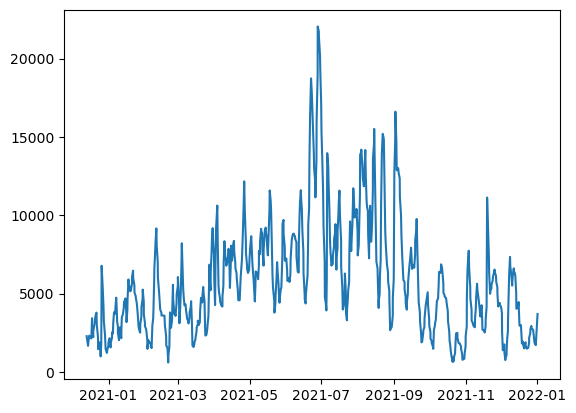

In [44]:
PRtovs2021_ros_sh = shift_time(PRtovs2021_ros,age_2018['forpr_ros3'][4][1460:],datelist_vs[1460:],base_adm[0],factor_adm[0])
PRtovs2021_rosb_sh = shift_time(PRtovs2021_rosb,age_2018['backvs_ros3'][4][1460:],datelist_vs[1460:],-base_adm[0],-factor_adm[0])

PRtovs2021_ros_m,PRtovs2021_rosb_m,c,PRtovs2021_ros_avg = merge(PRtovs2021_ros_sh,PRtovs2021_rosb_sh)
print(c)

plt.plot(PRtovs2021_ros_m.Transport)

#### Flow south through Rosario

In [45]:
#Separate for each year
## 2017
rostosouth_2017 = PRtovs2017_ros_avg + PRtoadm2017_ros_avg
date2017_rossh = list(rostosouth_2017.dropna().index)

mask = np.isin(datelist_dens,date2017_rossh)
densdiff_ros2017 = dens_diff_ros[mask]
date_dens_2017sh = np.array(datelist_dens)[mask]

corr_rostosouth2017,p = stats.spearmanr(densdiff_ros2017,rostosouth_2017.dropna())
print('2017:',corr_rostosouth2017)

## 2018
rostosouth_2018 = PRtovs2018_ros_avg + PRtoadm2018_ros_avg
date2018_rossh = list(rostosouth_2018.dropna().index)

mask = np.isin(datelist_dens,date2018_rossh)
densdiff_ros2018 = dens_diff_ros[mask]
date_dens_2018sh = np.array(datelist_dens)[mask]

corr_rostosouth2018,p = stats.spearmanr(densdiff_ros2018,rostosouth_2018.dropna())
print('2018:',corr_rostosouth2018)

##2019
rostosouth_2019 = PRtovs2019_ros_avg.dropna() + PRtoadm2019_ros_avg.dropna()
date2019_rossh = list(rostosouth_2019.dropna().index)

mask = np.isin(datelist_dens,date2019_rossh)
densdiff_ros2019 = dens_diff_ros[mask]
date_dens_2019sh = np.array(datelist_dens)[mask]

corr_rostosouth2019,p = stats.spearmanr(densdiff_ros2019,rostosouth_2019.dropna())
print('2019:',corr_rostosouth2019)

##2020
rostosouth_2020 = PRtovs2020_ros_avg.dropna() + PRtoadm2020_ros_avg.dropna()
date2020_rossh = list(rostosouth_2020.dropna().index)

mask = np.isin(datelist_dens,date2020_rossh)
densdiff_ros2020 = dens_diff_ros[mask]
date_dens_2020sh = np.array(datelist_dens)[mask]

corr_rostosouth2020,p = stats.spearmanr(densdiff_ros2020,rostosouth_2020.dropna())
print('2020:',corr_rostosouth2020)

##2021
rostosouth_2021 = PRtovs2021_ros_avg.dropna() + PRtoadm2021_ros_avg.dropna()
date2021_rossh = list(rostosouth_2021.dropna().index)

mask = np.isin(datelist_dens,date2021_rossh)
densdiff_ros2021 = dens_diff_ros[mask]
date_dens_2021sh = np.array(datelist_dens)[mask]

corr_rostosouth2021,p = stats.spearmanr(densdiff_ros2021,rostosouth_2021.dropna())
print('2021:',corr_rostosouth2021)


2017: 0.8026360800109054
2018: 0.8292558573214036
2019: 0.6999855275351025
2020: 0.7782638846760945
2021: 0.7886338537636968


In [46]:
rostosouth = PRtovs_ros_avg + PRtoadm_ros_avg
date_rossh = list(rostosouth.dropna().index)

mask = np.isin(datelist_dens,date_rossh)
densdiff_ros = dens_diff_ros[mask]
# densdiff_ros2 = dens_diff_rosVS[mask]
date_dens_sh = np.array(datelist_dens)[mask]

corr_rostosouth,p = stats.spearmanr(densdiff_ros,rostosouth.dropna())


In [47]:
# PRtoadm2018_ros_avg.dropna().to_csv('combined2timeseries/PRtoadm2018_ros_avg.csv',index_label='Date')
# rostosouth_2017.dropna().to_csv('combined2timeseries/rostosouth_2017.csv',index_label='Date')
# rostosouth_2018.dropna().to_csv('combined2timeseries/rostosouth_2018.csv',index_label='Date')
# rostosouth_2019.dropna().to_csv('combined2timeseries/rostosouth_2019.csv',index_label='Date')
# rostosouth_2020.dropna().to_csv('combined2timeseries/rostosouth_2020.csv',index_label='Date')
# rostosouth_2021.dropna().to_csv('combined2timeseries/rostosouth_2021.csv',index_label='Date')
# rostosouth.dropna().to_csv('combined2timeseries/rostosouth17-21.csv',index_label='Date')
# PRtovs2017_ros_avg.dropna().to_csv('combined2timeseries/PRtovs2017_ros_avg.csv',index_label='Date')
# PRtovs2018_ros_avg.dropna().to_csv('combined2timeseries/PRtovs2018_ros_avg.csv',index_label='Date')
# PRtovs2019_ros_avg.dropna().to_csv('combined2timeseries/PRtovs2019_ros_avg.csv',index_label='Date')
# PRtovs2020_ros_avg.dropna().to_csv('combined2timeseries/PRtovs2020_ros_avg.csv',index_label='Date')
# PRtovs2021_ros_avg.dropna().to_csv('combined2timeseries/PRtovs2021_ros_avg.csv',index_label='Date')
# PRtovs_ros_avg.dropna().to_csv('combined2timeseries/PRtovs_ros_avg.csv',index_label='Date')
# PRtoadm2017_ros_avg.dropna().to_csv('combined2timeseries/PRtoadm2017_ros_avg.csv',index_label='Date')
# PRtoadm2018_ros_avg.dropna().to_csv('combined2timeseries/PRtoadm2018_ros_avg.csv',index_label='Date')
# PRtoadm2019_ros_avg.dropna().to_csv('combined2timeseries/PRtoadm2019_ros_avg.csv',index_label='Date')
# PRtoadm2020_ros_avg.dropna().to_csv('combined2timeseries/PRtoadm2020_ros_avg.csv',index_label='Date')
# PRtoadm2021_ros_avg.dropna().to_csv('combined2timeseries/PRtoadm2021_ros_avg.csv',index_label='Date')
# PRtoadm_ros_avg.dropna().to_csv('combined2timeseries/PRtoadm_ros_avg.csv',index_label='Date')
# harotosouth.dropna().to_csv('combined2timeseries/harotosouth18-21.csv')